In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os, sys, gc, random
import datetime
from dateutil.relativedelta import relativedelta
import argparse

# Machine learning
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [3]:
## features.py

TOTAL_THRES = 300
# SEED = 444
# seed_everything(SEED) 

data_dir = '/opt/ml/code/input/train.csv'
model_dir = '/opt/ml/model'


# target_date를 기준으로 이전에 등장한 모든 고객에 대한 라벨 생성
def generate_label(df_original, target_date, total_thres=TOTAL_THRES, print_log=False):
    df = df_original.copy()

    # -- Extract ids of customers we have to predict
    customer_ids = df[df['ym'] < target_date]['customer_id'].unique()

    # -- Extract the raw value of label
    df = df[df['ym'] == target_date]
    monthly_data = df.groupby(['customer_id', 'ym'], as_index=False)[['total']].sum()
    
    # -- Make label
    label = pd.DataFrame({'customer_id': customer_ids})
    label['ym'] = target_date
    label = label.merge(monthly_data, on=['customer_id', 'ym'], how='left')
    label['total'].fillna(0.0, inplace=True) # imputing
    label['label'] = (label['total'] > total_thres).astype(int)
    label = label.sort_values('customer_id').reset_index(drop=True)

    # -- log
    if print_log:
        print(f"{target_date} - final label shape: {label.shape}")

    return label


# (1) str 값들 label encoding (2) 결손값 처리
def feature_preprocessing(train, test, features, do_imputing=True):
    X_train = train.copy()
    X_test = test.copy()

    categorical_columns = []

    for feature in features:
        if X_train[feature].dtype.name == 'object':
            categorical_columns.append(feature)

            if feature == 'country':
                X_train['country'] = (X_train['country'] == 'United Kingdom')
                X_test['country'] = (X_test['country'] == 'United Kingdom')
            else:
                le = LabelEncoder()
                le.fit(list(X_train[feature].values) + list(X_test[feature].values))
                
                X_train[feature] = le.transform(list(X_train[feature].values))
                X_test[feature] = le.transform(list(X_test[feature].values))

    print(f"Categorical features: {categorical_columns}")

    # 결측치 채우기 .. 현재 데이터에는 결측치가 없으나 그냥 연습용으로 ㅎㅎ
    if do_imputing:
        imputer = SimpleImputer(strategy='median') # 결측치는 중간값으로 채우기

        X_train[features] = imputer.fit_transform(X_train[features])
        X_test[features] = imputer.transform(X_test[features])

    return X_train, X_test


def generate_monthly_frame(df_original):
    """ 고객별 월별 구매데이터 반환. 결손 데이터는 0으로 처리 

    Args:
        df_original: 
            0   order_date   780502 non-null  object 
            1   customer_id  780502 non-null  int64  
            2   total        780502 non-null  float64
            3   ym           780502 non-null  object
            단, total 외에 quantity, price 등 수치 데이터들은 들어와도 무관.
            들어오는 모든 attribute에 대하여 동일 작업 수행 (월별 데이터 합)
    Returns:
         	            customer_id	    ym      	    total
            0	        12346	        2009-12	        187.2750
            1	        12346	        2010-01	        -22.2750
            2	        12346	        2010-02	        0.0000
            3	        12346	        2010-03	        44.6325
            4	        12346	        2010-04	        0.0000
            ...         ...	            ...	            ...
            141931	    18287	        2011-07	        0.0000
            141932	    18287	        2011-08	        0.0000
            141933	    18287	        2011-09	        0.0000
            141934	    18287	        2011-10	        1768.8000
            141935	    18287	        2011-11	        0.0000
    """
    df = df_original.copy()
    # df['ym'] = pd.to_datetime(df['order_date']).dt.strftime('%Y-%m')
    df.order_date = pd.to_datetime(df.order_date)

    # -- 데이터 프레임 내에 존재할 수 있는 모든 date를 담는 object
    times = pd.date_range(start=df.order_date.min(),
                            end=df.order_date.max(),
                            freq='1d')
    times = pd.to_datetime(times.strftime("%Y-%m-%d"))

    # -- 모든 customer_id, 모든 date를 담는 frame(nparray)을 순차적으로 생성  
    customer_id_frame = np.repeat(df.customer_id.unique(), len(times))
    time_frame = np.tile(times, len(df.customer_id.unique()))

    # -- customer_id_frame과 time_frame을 이용하여 
    #    고객 아이디와 각 날짜가 대응되는 Dataframe 생성
    frame = pd.DataFrame({'customer_id': customer_id_frame, 'order_date': time_frame})
    frame['ym'] = pd.to_datetime(frame.order_date).dt.strftime("%Y-%m")

    # -- 원본 데이터 프레임에서 구매내역을 월별로 집계(구매내역이 없는 달은 표시되지 않는 상태)
    df_group = df.groupby(['customer_id', 'ym']).sum().reset_index()
    
    # -- 이전에 만들었던 데이터 틀(프레임)도 같은 형태로 맞춰주기
    frame_group = frame.groupby(['customer_id', 'ym']).count().reset_index().drop('order_date', axis=1)

    # -- 둘을 결합, 구매/환불내역이 없는 달의 total은 0으로 처리
    df_merge = pd.merge(frame_group, df_group, on=['customer_id', 'ym'], how='left').fillna(0)

    return df_merge


def feature_engineering(df_original, target_date):
    """ monthly frame을 만들고 이를 기반으로 monthly 데이터 생성

        1. Drop 'description', 'price', 'quantity'
        2. Datetime "%Y-%m-%d %h-%m-%s" -> "%Y-%m" 
    
        Args:
            df_original:
                완전 원본.

            target_date: 
                ex. '2011-12'
    """

    df = df_original.copy()

    # dtype of order_date .. object->datetime
    df['ym'] = pd.to_datetime(df['order_date']).dt.strftime('%Y-%m')

    # Drop unnecessary columns
    df.drop(['order_id', 'product_id', 'description', 'price', 'country'], axis=1, inplace=True)

    # target date 이전 월 계산. train set의 라벨을 얻기 위해.
    d = datetime.datetime.strptime(target_date, "%Y-%m")
    prev_date = (d - relativedelta(months=1)).strftime("%Y-%m")
    init_date = df.order_date.min().strftime("%Y-%m")

    train = df[df['ym'] < prev_date]
    test = df[(df['ym'] < target_date) & (df['ym'] > init_date)]

    # labeling
    train_label = generate_label(df, prev_date)[['customer_id', 'ym', 'label']]
    test_label = generate_label(df, target_date)[['customer_id', 'ym', 'label']]

    # train/test preprocessing
    train_mondf = generate_monthly_frame(train)
    test_mondf = generate_monthly_frame(test)

    train_data = pd.pivot_table(train,
                                index='customer_id',
                                columns='ym',
                                values=['total', 'quantity']).fillna(0)
    test_data = pd.pivot_table(test,
                                index='customer_id',
                                columns='ym',
                                values=['total', 'quantity']).fillna(0)
    
    agg_funcs = ['mean', 'max', 'min', 'sum', 'std', 'skew']

    data_dfs = [train_data, test_data]
    label_dfs = [train_label, test_label]
    dfs_after = []

    for data, label in zip(data_dfs, label_dfs):
        for attribute in ['quantity', 'total']:
            for agg_func in agg_funcs:
                data[(attribute, agg_func)] = data.agg(agg_func, axis=1)
        after = pd.merge(data, label, on=['customer_id'], how='left')
        new_columns = ['customer_id'] + \
                      [f"{attribute[0]}_{idx}" for idx, attribute in enumerate(after.columns[1:24])] + \
                      [f"{attribute[0]}_{idx}" for idx, attribute in enumerate(after.columns[24:47])] + \
                      [f"{x[0]}_{x[1]}" for x in after.columns[47:59]] + \
                      list(after.columns[59:])

        after.columns = new_columns
        dfs_after.append(after)

    X_train, X_test = dfs_after
    features = X_train.drop(columns=['customer_id', 'label', 'ym']).columns
    
    print(f"X_train.shape: {X_train.shape}, X_test.shape: {X_test.shape}")

    return X_train, X_test, X_train['label'], features


def feature_engineering_before_agg(df_original, target_date):
    """ monthly frame을 만들고 이를 기반으로 monthly 데이터 생성

        1. Drop 'description', 'price', 'quantity'
        2. Datetime "%Y-%m-%d %h-%m-%s" -> "%Y-%m" 
    
        Args:
            df_original:
                완전 원본.

            target_date: 
                ex. '2011-12'
    """

    df = df_original.copy()

    # dtype of order_date .. object->datetime
    df['ym'] = pd.to_datetime(df['order_date']).dt.strftime('%Y-%m')

    # Drop unnecessary columns
    df.drop(['order_id', 'product_id', 'description', 'price', 'country'], axis=1, inplace=True)

    # target date 이전 월 계산. train set의 라벨을 얻기 위해.
    d = datetime.datetime.strptime(target_date, "%Y-%m")
    prev_date = (d - relativedelta(months=1)).strftime("%Y-%m")
    init_date = df.order_date.min().strftime("%Y-%m")

    train = df[df['ym'] < prev_date]
    test = df[(df['ym'] < target_date) & (df['ym'] > init_date)]

    # labeling
    train_label = generate_label(df, prev_date)[['customer_id', 'ym', 'label']]
    test_label = generate_label(df, target_date)[['customer_id', 'ym', 'label']]

    # train/test preprocessing
    train_mondf = generate_monthly_frame(train)
    test_mondf = generate_monthly_frame(test)

    train_data = pd.pivot_table(train,
                                index='customer_id',
                                columns='ym',
                                values=['total', 'quantity']).fillna(0)
    test_data = pd.pivot_table(test,
                                index='customer_id',
                                columns='ym',
                                values=['total', 'quantity']).fillna(0)
    
    return train_data, test_data 


def feature_engineering_all_date(df_original):
    """ monthly frame을 만들고 이를 기반으로 monthly 데이터 생성

        1. Drop 'description', 'price', 'quantity'
        2. Datetime "%Y-%m-%d %h-%m-%s" -> "%Y-%m" 
    
        Args:
            df_original:
                완전 원본.

            target_date: 
                ex. '2011-12'
    """

    df = df_original.copy()

    # dtype of order_date .. object->datetime
    df['ym'] = pd.to_datetime(df['order_date']).dt.strftime('%Y-%m')

    # train/test preprocessing
    mondf = generate_monthly_frame(df)

    data = pd.pivot_table(mondf,
                            index='customer_id',
                            columns='ym',
                            values=['total', 'quantity']).fillna(0)
    
    return data

In [8]:
## inference.py

data_dir = '/opt/ml/code/input' # os.environ['SM_CHANNEL_TRAIN']
output_dir = '/opt/ml/code/output' # os.environ['SM_OUTPUT_DATA_DIR']

data = pd.read_csv(data_dir + '/train.csv', parse_dates=['order_date'])
year_month = '2011-12'

In [18]:
train, test, y, features = feature_engineering(data, year_month)
train

X_train.shape: (5722, 61), X_test.shape: (5814, 61)


,customer_id,quantity_0,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8,...,quantity_std,quantity_skew,total_mean,total_max,total_min,total_sum,total_std,total_skew,ym,label
0,12346,5.200000,3.8,0.000000,1.000000,0.000000,0.000000,0.178571,0.0,0.000000,...,11.946214,3.863676,2.780554,64.389451,-10.211732,201.547066,29.987854,5.337941,2011-11,0
1,12347,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,57.656423,6.352477,16.738198,403.188685,0.000000,1290.313153,185.280412,5.896031,2011-11,0
2,12348,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,140.407114,6.061681,39.942203,965.262872,0.000000,3082.199613,443.436934,5.863039,2011-11,0
3,12349,-1.000000,0.0,0.000000,0.000000,10.282609,1.000000,0.000000,0.0,0.000000,...,123.188859,4.825845,31.437329,753.363212,-7.969500,2411.572169,350.923070,5.673087,2011-11,1
4,12350,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,12.585955,4.841143,3.314316,77.458670,0.000000,253.117424,36.662262,5.732811,2011-11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5717,18283,0.000000,0.0,1.225000,1.392405,0.000000,0.000000,0.000000,0.0,1.153846,...,11.294115,6.680253,3.435387,80.332866,0.000000,262.408352,37.499969,5.965315,2011-11,1
5718,18284,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,10.812615,4.920938,2.902601,67.600859,0.000000,221.438732,32.007483,5.763038,2011-11,0
5719,18285,0.000000,0.0,12.083333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,21.590924,4.763050,5.547091,131.047373,0.000000,425.043184,61.742345,5.692533,2011-11,0
5720,18286,6.705882,0.0,0.000000,0.000000,0.000000,0.000000,-5.333333,0.0,9.880000,...,15.728017,-1.272293,0.676157,44.933382,-59.400000,21.369691,18.266009,-1.138000,2011-11,0


In [17]:
pdf_train, pdf_test = feature_engineering_before_agg(data, year_month)
pdf_train

quantity                                                     \
ym            2009-12 2010-01    2010-02   2010-03    2010-04    2010-05   
customer_id                                                                
12346        5.200000     3.8   0.000000  1.000000   0.000000   0.000000   
12347        0.000000     0.0   0.000000  0.000000   0.000000   0.000000   
12348        0.000000     0.0   0.000000  0.000000   0.000000   0.000000   
12349       -1.000000     0.0   0.000000  0.000000  10.282609   1.000000   
12350        0.000000     0.0   0.000000  0.000000   0.000000   0.000000   
...               ...     ...        ...       ...        ...        ...   
18283        0.000000     0.0   1.225000  1.392405   0.000000   0.000000   
18284        0.000000     0.0   0.000000  0.000000   0.000000   0.000000   
18285        0.000000     0.0  12.083333  0.000000   0.000000   0.000000   
18286        6.705882     0.0   0.000000  0.000000   0.000000   0.000000   
18287       -2.000000     0.0   0.000000  0.000000   0.000000  13.555556   

                                                    ...      total             \
ym            2010-06 2010-07   2010-08    2010-09  ...    2011-01    2011-02   
customer_id                                         ...                         
12346        0.178571     0.0  0.000000   0.000000  ...   0.000000   0.000000   
12347        0.000000     0.0  0.000000   0.000000  ...  27.048052   0.000000   
12348        0.000000     0.0  0.000000  18.650000  ...  62.546000   0.000000   
12349        0.000000     0.0  0.000000   0.000000  ...   0.000000   0.000000   
12350        0.000000     0.0  0.000000   0.000000  ...   0.000000  32.456471   
...               ...     ...       ...        ...  ...        ...        ...   
18283        0.000000     0.0  1.153846   0.000000  ...   3.491955   5.743707   
18284        0.000000     0.0  0.000000   0.000000  ...   0.000000   0.000000   
18285        0.000000     0.0  0.000000   0.000000  ...   0.000000   0.000000   
18286       -5.333333     0.0  9.880000   0.000000  ...   0.000000   0.000000   
18287        0.000000     0.0  0.000000  24.190476  ...   0.000000   0.000000   

                                                                         \
ym          2011-03     2011-04    2011-05    2011-06 2011-07   2011-08   
customer_id                                                               
12346           0.0    0.000000   0.000000   0.000000  0.0000   0.00000   
12347           0.0   43.742188   0.000000  35.064333  0.0000  43.86825   
12348           0.0  121.110000   0.000000   0.000000  0.0000   0.00000   
12349           0.0    0.000000   0.000000   0.000000  0.0000   0.00000   
12350           0.0    0.000000   0.000000   0.000000  0.0000   0.00000   
...             ...         ...        ...        ...     ...       ...   
18283           0.0    3.468000   3.800351   4.892580  4.1967   0.00000   
18284           0.0    0.000000   0.000000   0.000000  0.0000   0.00000   
18285           0.0    0.000000   0.000000   0.000000  0.0000   0.00000   
18286           0.0    0.000000   0.000000   0.000000  0.0000   0.00000   
18287           0.0    0.000000  43.541793   0.000000  0.0000   0.00000   

                                    
ym              2011-09    2011-10  
customer_id                         
12346          0.000000   0.000000  
12347          0.000000  45.438894  
12348        170.500000   0.000000  
12349          0.000000   0.000000  
12350          0.000000   0.000000  
...                 ...        ...  
18283          4.735851   4.906145  
18284          0.000000   0.000000  
18285          0.000000   0.000000  
18286          0.000000   0.000000  
18287          0.000000  43.141463  

[5722 rows x 46 columns]

In [19]:
train_total = pdf_train['total']
train_total

ym,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,...,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10
customer_id,,,,,,,,,,,,,,,,,,,,,
12346,37.455000,-4.455,0.000000,8.926500,0.000000,0.000000,-10.211732,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
12347,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,27.048052,0.000000,0.0,43.742188,0.000000,35.064333,0.0000,43.86825,0.000000,45.438894
12348,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,18.328200,...,62.546000,0.000000,0.0,121.110000,0.000000,0.000000,0.0000,0.00000,170.500000,0.000000
12349,-7.969500,0.000,0.000000,0.000000,38.327348,330.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
12350,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,32.456471,0.0,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0.000000,0.000,3.997125,4.910734,0.000000,0.000000,0.000000,0.0,3.892308,0.000000,...,3.491955,5.743707,0.0,3.468000,3.800351,4.892580,4.1967,0.00000,4.735851,4.906145
18284,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000
18285,0.000000,0.000,58.712500,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000


In [22]:
total = feature_engineering_all_date(data)
total

quantity                                                          \
ym           2009-12 2010-01 2010-02 2010-03 2010-04 2010-05 2010-06 2010-07   
customer_id                                                                    
12346           26.0    19.0     0.0     5.0     0.0     0.0     5.0     0.0   
12347            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
12348            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
12349           -5.0     0.0     0.0     0.0   473.0     1.0     0.0     0.0   
12350            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...              ...     ...     ...     ...     ...     ...     ...     ...   
18283            0.0     0.0    49.0   110.0     0.0     0.0     0.0     0.0   
18284            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
18285            0.0     0.0   145.0     0.0     0.0     0.0     0.0     0.0   
18286          114.0     0.0     0.0     0.0     0.0     0.0   -16.0     0.0   
18287           -2.0     0.0     0.0     0.0     0.0   732.0     0.0     0.0   

                             ...     total                               \
ym          2010-08 2010-09  ...   2011-02 2011-03    2011-04   2011-05   
customer_id                  ...                                          
12346           0.0     0.0  ...    0.0000     0.0     0.0000     0.000   
12347           0.0     0.0  ...    0.0000     0.0  1049.8125     0.000   
12348           0.0   373.0  ...    0.0000     0.0   605.5500     0.000   
12349           0.0     0.0  ...    0.0000     0.0     0.0000     0.000   
12350           0.0     0.0  ...  551.7600     0.0     0.0000     0.000   
...             ...     ...  ...       ...     ...        ...       ...   
18283          45.0     0.0  ...  166.5675     0.0   190.7400   140.613   
18284           0.0     0.0  ...    0.0000     0.0     0.0000     0.000   
18285           0.0     0.0  ...    0.0000     0.0     0.0000     0.000   
18286         494.0     0.0  ...    0.0000     0.0     0.0000     0.000   
18287           0.0   508.0  ...    0.0000     0.0     0.0000  1262.712   

                                                                         
ym           2011-06   2011-07   2011-08  2011-09    2011-10    2011-11  
customer_id                                                              
12346          0.000    0.0000    0.0000    0.000     0.0000     0.0000  
12347        631.158    0.0000  965.1015    0.000  2135.6280     0.0000  
12348          0.000    0.0000    0.0000  511.500     0.0000     0.0000  
12349          0.000    0.0000    0.0000    0.000     0.0000  2899.9575  
12350          0.000    0.0000    0.0000    0.000     0.0000     0.0000  
...              ...       ...       ...      ...        ...        ...  
18283        489.258  230.8185    0.0000  222.585   186.4335  1052.2215  
18284          0.000    0.0000    0.0000    0.000     0.0000     0.0000  
18285          0.000    0.0000    0.0000    0.000     0.0000     0.0000  
18286          0.000    0.0000    0.0000    0.000     0.0000     0.0000  
18287          0.000    0.0000    0.0000    0.000  1768.8000     0.0000  

[5914 rows x 48 columns]

In [23]:
only_total = total['total']
only_total

ym,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,...,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
customer_id,,,,,,,,,,,,,,,,,,,,,
12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,...,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,...,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000
12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,...,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000
12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,...,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575
12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,...,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,...,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215
18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,...,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,...,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000


In [126]:
df = only_total

In [127]:
df.T

customer_id,12346,12347,12348,12349,12350,12351,12352,12353,12354,12355,...,18278,18279,18280,18281,18282,18283,18284,18285,18286,18287
ym,,,,,,,,,,,,,,,,,,,,,
2009-12,187.2750,0.0000,0.000,-39.8475,0.00,0.0000,0.0000,0.000,0.00,0.0000,...,0.000,0.000,0.0000,0.000,0.000,0.0000,0.000,0.00,763.8675,-8.4150
2010-01,-22.2750,0.0000,0.000,0.0000,0.00,0.0000,0.0000,0.000,0.00,0.0000,...,0.000,0.000,0.0000,0.000,0.000,0.0000,0.000,0.00,0.0000,0.0000
2010-02,0.0000,0.0000,0.000,0.0000,0.00,0.0000,0.0000,0.000,0.00,0.0000,...,0.000,0.000,0.0000,0.000,0.000,159.8850,0.000,704.55,0.0000,0.0000
2010-03,44.6325,0.0000,0.000,0.0000,0.00,0.0000,0.0000,0.000,0.00,0.0000,...,0.000,0.000,0.0000,0.000,0.000,387.9480,0.000,0.00,0.0000,0.0000
2010-04,0.0000,0.0000,0.000,1763.0580,0.00,0.0000,0.0000,0.000,0.00,0.0000,...,0.000,0.000,0.0000,0.000,0.000,0.0000,0.000,0.00,0.0000,0.0000
2010-05,0.0000,0.0000,0.000,330.0000,0.00,0.0000,0.0000,0.000,0.00,805.5465,...,0.000,0.000,0.0000,198.528,0.000,0.0000,0.000,0.00,0.0000,1768.1565
2010-06,-285.9285,0.0000,0.000,0.0000,0.00,0.0000,0.0000,0.000,0.00,0.0000,...,0.000,0.000,0.0000,0.000,0.000,0.0000,0.000,0.00,-178.2000,0.0000
2010-07,0.0000,0.0000,0.000,0.0000,0.00,0.0000,0.0000,0.000,0.00,0.0000,...,0.000,381.711,0.0000,0.000,0.000,0.0000,0.000,0.00,0.0000,0.0000
2010-08,0.0000,0.0000,0.000,0.0000,0.00,0.0000,0.0000,0.000,0.00,0.0000,...,0.000,0.000,0.0000,0.000,0.000,151.8000,0.000,0.00,1375.2420,0.0000


In [128]:
df

ym,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,...,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
customer_id,,,,,,,,,,,,,,,,,,,,,
12346,187.2750,-22.275,0.000,44.6325,0.000,0.0000,-285.9285,0.0,0.000,0.000,...,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
12347,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,...,0.0000,0.0,1049.8125,0.000,631.158,0.0000,965.1015,0.000,2135.6280,0.0000
12348,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,366.564,...,0.0000,0.0,605.5500,0.000,0.000,0.0000,0.0000,511.500,0.0000,0.0000
12349,-39.8475,0.000,0.000,0.0000,1763.058,330.0000,0.0000,0.0,0.000,0.000,...,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,2899.9575
12350,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,...,551.7600,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,0.0000,0.000,159.885,387.9480,0.000,0.0000,0.0000,0.0,151.800,0.000,...,166.5675,0.0,190.7400,140.613,489.258,230.8185,0.0000,222.585,186.4335,1052.2215
18284,0.0000,0.000,0.000,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,...,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000
18285,0.0000,0.000,704.550,0.0000,0.000,0.0000,0.0000,0.0,0.000,0.000,...,0.0000,0.0,0.0000,0.000,0.000,0.0000,0.0000,0.000,0.0000,0.0000


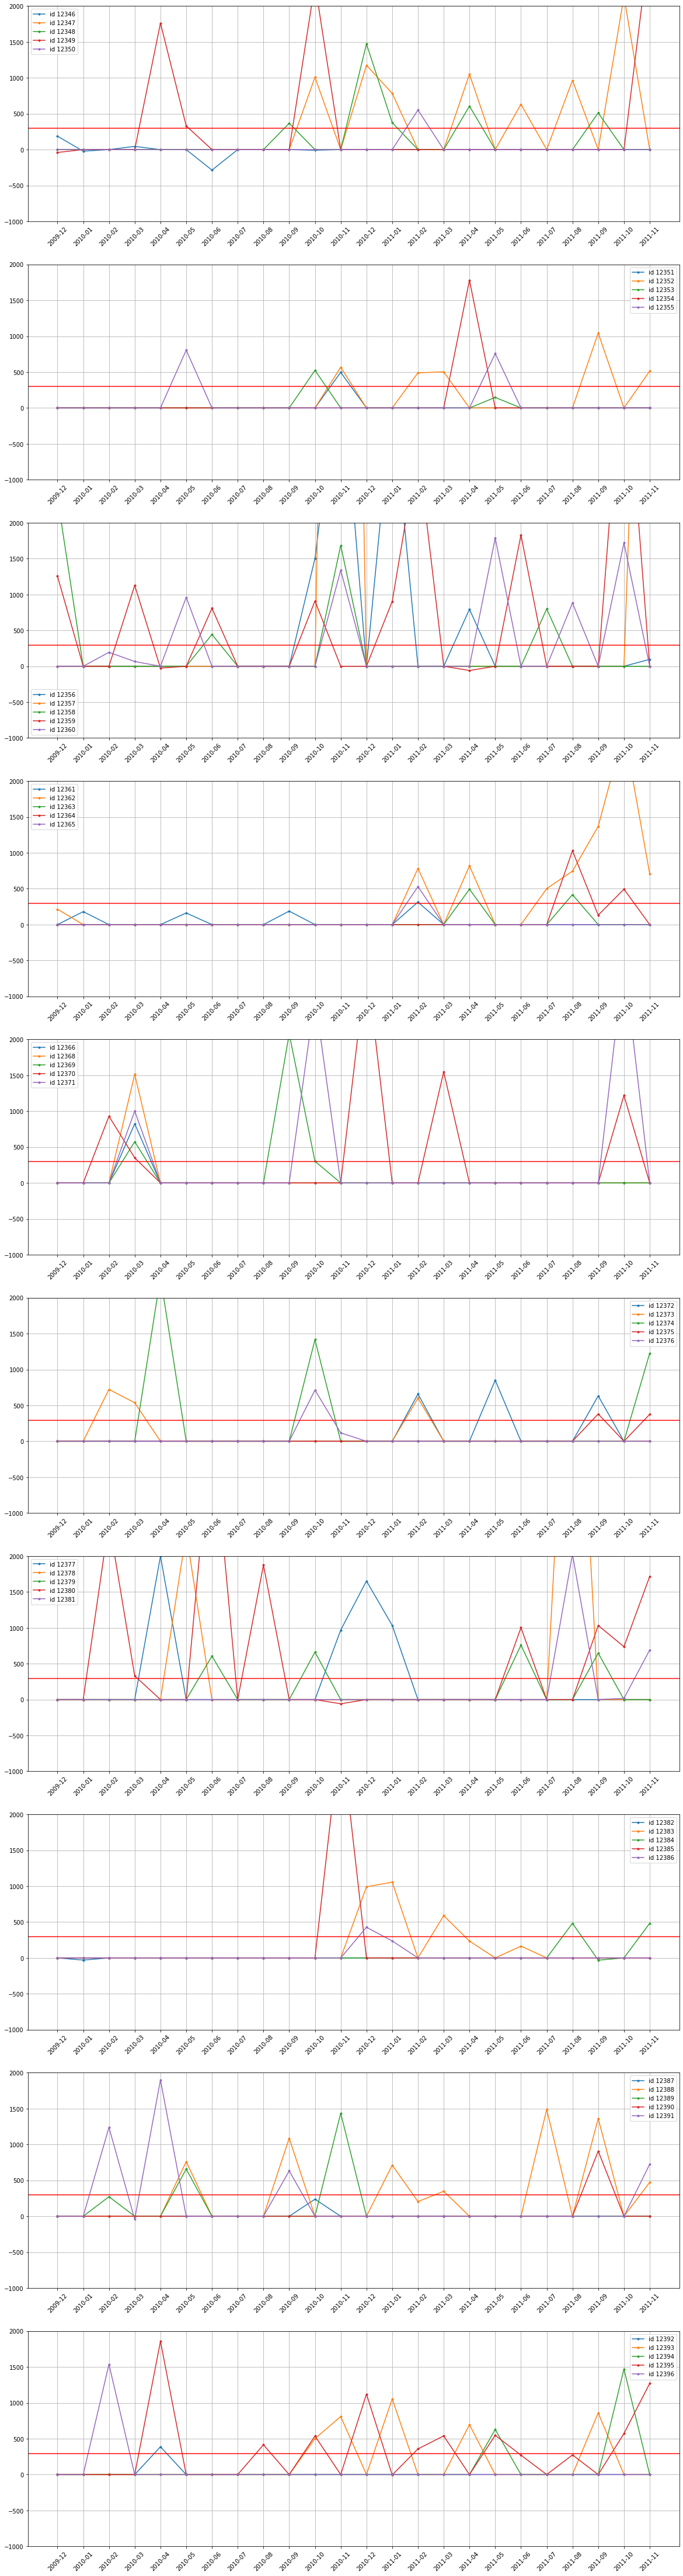

In [150]:
ncols = 1
nrows = 10
num_plot = 5
fig, axs = plt.subplots(figsize=(20, 80), ncols=ncols, nrows=nrows)

plt.xticks(rotation=45)
# plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold", 
#          horizontalalignment="left",)
# plt.ylim([-1000, 3000])
for i in range(nrows):
    for j in range(num_plot):
        axs[i].plot(df.iloc[i * num_plot + j, :], marker='.', label=f"id {df.index[i * num_plot + j]}")
        axs[i].legend(loc='best')
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].set_ylim([-1000, 2000])
        axs[i].axhline(y=300, color='r', linewidth=1.1)
        axs[i].grid(True)

plt.show()

In [110]:
def generate_monthly_frame(df_original, pdf_values):
    """ 고객별 월별 구매데이터 반환. 결손 데이터는 0으로 처리 

    Args:
        df_original: 
            0   order_date   780502 non-null  object 
            1   customer_id  780502 non-null  int64  
            2   total        780502 non-null  float64
            3   ym           780502 non-null  object
            단, total 외에 quantity, price 등 수치 데이터들은 들어와도 무관.
            들어오는 모든 attribute에 대하여 동일 작업 수행 (월별 데이터 합)
        pdf_values:
            pivot table 만들 때 사용할 value list
            i.e. pdf_values = ['total', 'quantity']
    Returns:
         	            customer_id	    ym      	    total
            0	        12346	        2009-12	        187.2750
            1	        12346	        2010-01	        -22.2750
            2	        12346	        2010-02	        0.0000
            3	        12346	        2010-03	        44.6325
            4	        12346	        2010-04	        0.0000
            ...         ...	            ...	            ...
            141931	    18287	        2011-07	        0.0000
            141932	    18287	        2011-08	        0.0000
            141933	    18287	        2011-09	        0.0000
            141934	    18287	        2011-10	        1768.8000
            141935	    18287	        2011-11	        0.0000
    """
    df = df_original.copy()
    # df['ym'] = pd.to_datetime(df['order_date']).dt.strftime('%Y-%m')
    df.order_date = pd.to_datetime(df.order_date)

    # -- 데이터 프레임 내에 존재할 수 있는 모든 date를 담는 object
    times = pd.date_range(start=df.order_date.min(),
                            end=df.order_date.max(),
                            freq='1d')
    times = pd.to_datetime(times.strftime("%Y-%m-%d"))

    # -- 모든 customer_id, 모든 date를 담는 frame(nparray)을 순차적으로 생성  
    customer_id_frame = np.repeat(df.customer_id.unique(), len(times))
    time_frame = np.tile(times, len(df.customer_id.unique()))

    # -- customer_id_frame과 time_frame을 이용하여 
    #    고객 아이디와 각 날짜가 대응되는 Dataframe 생성
    frame = pd.DataFrame({'customer_id': customer_id_frame, 'order_date': time_frame})
    frame['ym'] = pd.to_datetime(frame.order_date).dt.strftime("%Y-%m")

    # -- 원본 데이터 프레임에서 구매내역을 월별로 집계(구매내역이 없는 달은 표시되지 않는 상태)
    df_group = df.groupby(['customer_id', 'ym']).sum().reset_index()
    
    # -- 이전에 만들었던 데이터 틀(프레임)도 같은 형태로 맞춰주기
    frame_group = frame.groupby(['customer_id', 'ym']).count().reset_index().drop('order_date', axis=1)

    # -- 둘을 결합, 구매/환불내역이 없는 달의 total은 0으로 처리
    df_merge = pd.merge(frame_group, df_group, on=['customer_id', 'ym'], how='left').fillna(0)

    # -- pivot table
    pdf_merge = pd.pivot_table(data=df_merge,
                              values=pdf_values,
                              index='customer_id',
                              columns='ym',
                              fill_value=0)

    return pdf_merge

In [101]:
def nnff(x, total_thres=0):
    x_sum = x[x > total_thres].sum()
    x_count = x[x > total_thres].count()
    x_mean = x_sum / x_count
    return x_mean

def generate_label_total(df_original, target_date, total_thres=TOTAL_THRES, print_log=False):
    """ Labeling based on whether customer purchase over $300

    Args:
        df_original: pivot
        total_thres: label is 1 when 'total' excced 'total_thres'
    """

    # https://stats.stackexchange.com/questions/135061/best-method-for-short-time-series
    # ㅋㅋ 그냥 평균. 하지만 평균도 아주 강력하다 ㅇ _ㅇ 

    df = df_original.copy()

    # -- Extract ids of customers we have to predict
    customer_ids = df[df['ym'] < target_date]['customer_id'].unique()

    
    # -- Extract the raw value of label
    df = df[df['ym'] == target_date]
    grouped = df.groupby(['customer_id', 'ym'], as_index=False)[['total']].sum()
    grouped2 = df.groupby(['customer_id', 'ym'], as_index=False)[['total']].agg(nnff, total_thres=20)
    grouped3 = df.groupby(['customer_id', 'ym'], as_index=False)[['total']].mean()
    
#     grouped_above_thres = grouped[grouped['total'] > total_thres]
#     print(grouped_above_thres)
    print(grouped)
    print(grouped3)
    print(grouped2)
    

In [67]:
data_dir = '/opt/ml/code/input' # os.environ['SM_CHANNEL_TRAIN']
output_dir = '/opt/ml/code/output' # os.environ['SM_OUTPUT_DATA_DIR']

data = pd.read_csv(data_dir + '/train.csv', parse_dates=['order_date'])
year_month = '2011-12'

In [111]:
df = data.copy()

# dtype of order_date .. object->datetime
df['ym'] = pd.to_datetime(df['order_date']).dt.strftime('%Y-%m')

# Drop unnecessary columns
df.drop(['order_id', 'product_id', 'description', 'price', 'country'], axis=1, inplace=True)

train = df[df['ym'] < '2011-10']
pdf_values = ['total']
train_data = generate_monthly_frame(train, pdf_values)
train_data

total                                                  \
ym            2009-12 2010-01  2010-02   2010-03   2010-04    2010-05   
customer_id                                                             
12346        187.2750 -22.275    0.000   44.6325     0.000     0.0000   
12347          0.0000   0.000    0.000    0.0000     0.000     0.0000   
12348          0.0000   0.000    0.000    0.0000     0.000     0.0000   
12349        -39.8475   0.000    0.000    0.0000  1763.058   330.0000   
12350          0.0000   0.000    0.000    0.0000     0.000     0.0000   
...               ...     ...      ...       ...       ...        ...   
18283          0.0000   0.000  159.885  387.9480     0.000     0.0000   
18284          0.0000   0.000    0.000    0.0000     0.000     0.0000   
18285          0.0000   0.000  704.550    0.0000     0.000     0.0000   
18286        763.8675   0.000    0.000    0.0000     0.000     0.0000   
18287         -8.4150   0.000    0.000    0.0000     0.000  1768.1565   

                                                   ...                       \
ym            2010-06 2010-07   2010-08   2010-09  ...    2010-12   2011-01   
customer_id                                        ...                        
12346       -285.9285     0.0     0.000     0.000  ...     0.0000    0.0000   
12347          0.0000     0.0     0.000     0.000  ...  1174.4535  784.3935   
12348          0.0000     0.0     0.000   366.564  ...  1473.1200  375.2760   
12349          0.0000     0.0     0.000     0.000  ...     0.0000    0.0000   
12350          0.0000     0.0     0.000     0.000  ...     0.0000    0.0000   
...               ...     ...       ...       ...  ...        ...       ...   
18283          0.0000     0.0   151.800     0.000  ...     0.0000  352.6875   
18284          0.0000     0.0     0.000     0.000  ...     0.0000    0.0000   
18285          0.0000     0.0     0.000     0.000  ...     0.0000    0.0000   
18286       -178.2000     0.0  1375.242     0.000  ...     0.0000    0.0000   
18287          0.0000     0.0     0.000  1472.790  ...     0.0000    0.0000   

                                                                       \
ym            2011-02 2011-03    2011-04   2011-05  2011-06   2011-07   
customer_id                                                             
12346          0.0000     0.0     0.0000     0.000    0.000    0.0000   
12347          0.0000     0.0  1049.8125     0.000  631.158    0.0000   
12348          0.0000     0.0   605.5500     0.000    0.000    0.0000   
12349          0.0000     0.0     0.0000     0.000    0.000    0.0000   
12350        551.7600     0.0     0.0000     0.000    0.000    0.0000   
...               ...     ...        ...       ...      ...       ...   
18283        166.5675     0.0   190.7400   140.613  489.258  230.8185   
18284          0.0000     0.0     0.0000     0.000    0.000    0.0000   
18285          0.0000     0.0     0.0000     0.000    0.000    0.0000   
18286          0.0000     0.0     0.0000     0.000    0.000    0.0000   
18287          0.0000     0.0     0.0000  1262.712    0.000    0.0000   

                                
ym            2011-08  2011-09  
customer_id                     
12346          0.0000    0.000  
12347        965.1015    0.000  
12348          0.0000  511.500  
12349          0.0000    0.000  
12350          0.0000    0.000  
...               ...      ...  
18283          0.0000  222.585  
18284          0.0000    0.000  
18285          0.0000    0.000  
18286          0.0000    0.000  
18287          0.0000    0.000  

[5501 rows x 22 columns]

In [144]:
target_date='2011-09'
status_thres=30
df = train.copy()

# -- Extract ids of customers we have to predict
customer_ids = df[df['ym'] < target_date]['customer_id'].unique()

# -- Extract the raw value of label
df = df[df['ym'] == target_date]
monthly_data = df.groupby(['customer_id', 'ym'], as_index=False)[['total']].sum()

# -- Make label
label = pd.DataFrame({'customer_id': customer_ids})
label['ym'] = target_date
label = label.merge(monthly_data, on=['customer_id', 'ym'], how='left')
label['total'].fillna(0.0, inplace=True) # imputing
label['label'] = (label['total'] > status_thres).astype(int)
label = label.sort_values('customer_id').reset_index(drop=True)
# label['label'].value_counts()

0    4246
1    1068
Name: label, dtype: int64

In [150]:
label = train_data[train_data > 20].mean(axis=1)
label = (label > 300).astype(int)
label = label.sort_index().to_frame().reset_index()
label

,customer_id,0
0,12346,0
1,12347,1
2,12348,1
3,12349,1
4,12350,1
...,...,...
5496,18283,0
5497,18284,1
5498,18285,1
5499,18286,1


In [118]:
train_data['mean'] = train_data[.sum(axis=1)
train_data

total                                                  \
ym            2009-12 2010-01  2010-02   2010-03   2010-04    2010-05   
customer_id                                                             
12346        187.2750 -22.275    0.000   44.6325     0.000     0.0000   
12347          0.0000   0.000    0.000    0.0000     0.000     0.0000   
12348          0.0000   0.000    0.000    0.0000     0.000     0.0000   
12349        -39.8475   0.000    0.000    0.0000  1763.058   330.0000   
12350          0.0000   0.000    0.000    0.0000     0.000     0.0000   
...               ...     ...      ...       ...       ...        ...   
18283          0.0000   0.000  159.885  387.9480     0.000     0.0000   
18284          0.0000   0.000    0.000    0.0000     0.000     0.0000   
18285          0.0000   0.000  704.550    0.0000     0.000     0.0000   
18286        763.8675   0.000    0.000    0.0000     0.000     0.0000   
18287         -8.4150   0.000    0.000    0.0000     0.000  1768.1565   

                                                   ...                      \
ym            2010-06 2010-07   2010-08   2010-09  ...   2011-01   2011-02   
customer_id                                        ...                       
12346       -285.9285     0.0     0.000     0.000  ...    0.0000    0.0000   
12347          0.0000     0.0     0.000     0.000  ...  784.3935    0.0000   
12348          0.0000     0.0     0.000   366.564  ...  375.2760    0.0000   
12349          0.0000     0.0     0.000     0.000  ...    0.0000    0.0000   
12350          0.0000     0.0     0.000     0.000  ...    0.0000  551.7600   
...               ...     ...       ...       ...  ...       ...       ...   
18283          0.0000     0.0   151.800     0.000  ...  352.6875  166.5675   
18284          0.0000     0.0     0.000     0.000  ...    0.0000    0.0000   
18285          0.0000     0.0     0.000     0.000  ...    0.0000    0.0000   
18286       -178.2000     0.0  1375.242     0.000  ...    0.0000    0.0000   
18287          0.0000     0.0     0.000  1472.790  ...    0.0000    0.0000   

                                                                       \
ym          2011-03    2011-04   2011-05  2011-06   2011-07   2011-08   
customer_id                                                             
12346           0.0     0.0000     0.000    0.000    0.0000    0.0000   
12347           0.0  1049.8125     0.000  631.158    0.0000  965.1015   
12348           0.0   605.5500     0.000    0.000    0.0000    0.0000   
12349           0.0     0.0000     0.000    0.000    0.0000    0.0000   
12350           0.0     0.0000     0.000    0.000    0.0000    0.0000   
...             ...        ...       ...      ...       ...       ...   
18283           0.0   190.7400   140.613  489.258  230.8185    0.0000   
18284           0.0     0.0000     0.000    0.000    0.0000    0.0000   
18285           0.0     0.0000     0.000    0.000    0.0000    0.0000   
18286           0.0     0.0000     0.000    0.000    0.0000    0.0000   
18287           0.0     0.0000  1262.712    0.000    0.0000    0.0000   

                           mean  
ym           2011-09             
customer_id                      
12346          0.000   -3.88050  
12347          0.000  255.17925  
12348        511.500  151.45500  
12349          0.000  198.52425  
12350          0.000   25.08000  
...              ...        ...  
18283        222.585  127.96500  
18284          0.000   32.75100  
18285          0.000   32.02500  
18286          0.000   89.13225  
18287          0.000  232.94175  

[5501 rows x 23 columns]

In [117]:
for customer_id, totals in train_data.iterrows():
    print(index)
    print()
    for total in totals:
        print(total)
    assert 0

12346

187.275
-22.27499999999995
0.0
44.63250000000001
0.0
0.0
-285.9285000000001
0.0
0.0
0.0
-9.075
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


AssertionError: 